In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import astropy.units as u
from scipy.optimize import Bounds
import matplotlib.lines as mlines
from iminuit import Minuit
from iminuit import minimize as iminuit_minimize
from scipy.optimize import OptimizeResult
import time
import multiprocessing
import emcee
from multiprocessing import Pool

x0 = []

def magtoflux(mag, zeropint = 27.615):
    return 10.**(-0.4*(mag - zeropint))

def fit_model(event, parameters_to_fit, steps=500, walkers=100, data_ref=0):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    global x0
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # Create initial starting points for all walkers.
    nwalkers, ndim = walkers, len(x0)
    p0state = x0 + 1e-4 * np.random.randn(nwalkers, ndim)

   
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(event, parameters_to_fit))
        #Run MCMC
    pos, prob, state = sampler.run_mcmc(p0state, steps, progress=True); 


    return sampler, pos, prob, state

def plot_chain(sampler, parameters_to_fit):
    fig, axes = plt.subplots(len(parameters_to_fit)+1, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    chisq = -2.*sampler.get_log_prob()
    labels = parameters_to_fit
    for i in range(sampler.ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)
    
    ax = axes[-1]
    ax.plot(chisq, "k", alpha=0.3)
    ax.set_xlim(0, len(chisq))
    ax.set_ylabel("Chi2")
    

    axes[-1].set_xlabel("step number")
    plt.show()

def log_prior(theta, x0, parameters_to_fit):
    ''' bounds on parameter
    
    Parameters
    ----------
    theta: list; parameters for samplem draw'''

    # theta = [t_0, u_0, t_E, rho]
    for index, key in enumerate(parameters_to_fit):
        if key == 't_0':
            t0 = theta[index]
            t0_ig = x0[index]
        if key == 'u_0':
            u0 = theta[index]
        if key == 't_E':
            tE = theta[index]
            tE_ig = x0[index]
        if key == 'rho':
            rho = theta[index]
        if key == 's':
            s = theta[index]
        if key == 'q':
            q = theta[index]
        if key == 'alpha':
            alpha = theta[index]
        if len(parameters_to_fit) < 7:
            s,q,alpha = 1., 0.5, 1.
    
    if -5. < t0 - t0_ig < 5. and -10. < u0 < 10. and -3. < tE - tE_ig < 3. and 1e-5 < rho < 1. and 0.001 < s < 10. and 1e-6 < q < 1. and 0. < alpha < 360.:
        return 0.

    return -np.inf

def log_likelihood(theta, event, parameters_to_fit):
    '''updating event object and calculating chi2'''
    for (index, key) in enumerate(parameters_to_fit):
        setattr(event.model.parameters, key, theta[index])
    ll = -1./2. * event.get_chi2_for_dataset(0)
    return ll

def log_probability(theta, event, parameters_to_fit):
    global x0
    lp = 0.
    lp += log_prior(theta, x0, parameters_to_fit)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, event, parameters_to_fit)

In [6]:
fu0 = -0.015
falpha = 0.0
alpha = 360. - falpha

file_name = "../Multiple_lc_run1/s20p2s31p0psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)

print("Working on u0 = %.3f and alpha = %.1f"%(fu0,alpha))
#Read CB data
hjd, cbflux, cbflux_err = np.loadtxt(file_name+"_flux.txt", usecols=[0,1,2], unpack=True)
my_data = mm.MulensData([hjd, cbflux, cbflux_err], phot_fmt="flux", chi2_fmt="flux")
print("{:} file was imported".format(file_name))
true_params = np.loadtxt(file_name+"_info.txt", skiprows=1)
params_cb = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s2": true_params[3], "q2": true_params[4], "alpha": true_params[5], "rho": true_params[6], "s3": true_params[7], "q3": true_params[8], "psi": true_params[9]}

#Read binary data
hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

#Read planet data
hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
my_data_planet = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
params_planet = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

true_chisq = len(cbflux) - len(params_bin)
true_chisq_pspl = len(cbflux) - 4




#Create models
t_0 = params_bin['t_0']
u_0 = params_bin['u_0']
t_E = params_bin['t_E']
rho = params_bin['rho']
sbin = params_bin['s']
qbin = params_bin['q']
alphabin = params_bin['alpha']
splanet = params_planet['s']
qplanet = params_planet['q']
alphaplanet = params_planet['alpha']
u0planet = params_planet['u_0']
gamma = 1.25

pspl_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 'rho': rho})
pspl_model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
planet_model = mm.Model({'t_0': t_0, 'u_0': u0planet, 't_E': t_E, 's': splanet, 'q': qplanet, 'alpha': alphaplanet, 'rho': rho})
planet_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
binary_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': sbin, 'q': qbin, 'alpha': alphabin, 'rho': rho})
binary_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])



#Fit planet model to planet data

sgns = np.random.choice([-1,1], size = 7)
planet2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
planet2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
params_planetinit = {'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
my_event_planet = mm.Event(datasets=[my_data_planet], model=planet2_model)
init_fit = mm.FitData(dataset=my_data_planet, model=planet2_model)
init_fit.fit_fluxes()
initsourceflux = init_fit.source_flux
initblendflux = init_fit.blend_flux
deltax2init = my_event_planet.get_chi2_for_dataset(0)- true_chisq
#print("Initial delta chi-square planet-planet = ", deltax2init)
parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
sampler = fit_model(my_event_planet, parameters_to_fit, steps=600, walkers=50)



Working on u0 = -0.015 and alpha = 360.0
../Multiple_lc_run1/s20p2s31p0psi60.0alpha0.0/u-0.015alpha360 file was imported


You must install the tqdm library to use progress indicators with emcee


emcee: Exception while calling your likelihood function:
  params: [ 2.00024830e+03 -1.80697748e-02  3.07511753e+01  3.32267588e-03
  9.31704398e-01  1.23111111e-04  2.95729885e+02  2.00024918e+03
 -1.60056907e-02  3.07538552e+01 -1.15311628e-03  9.75444238e-01
  2.79460831e-03  2.95732958e+02]
  args: 

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

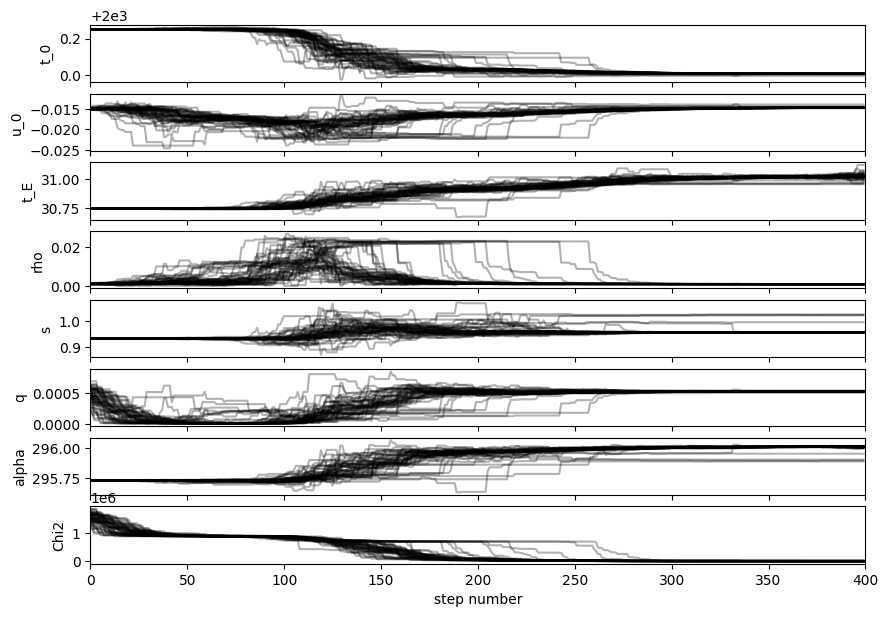

In [3]:
plot_chain(sampler[0], parameters_to_fit)
#sampler[0]

In [5]:
samples = sampler[0].get_chain(flat=True)
log_prob = sampler[0].get_log_prob(flat=True)
x2 = -2. * log_prob
#find index for minimum chi2
minind = np.argmin(x2)
#find best fit parameters
best_params = samples[minind, :]
print(best_params, x2[minind]-true_chisq)

[ 2.00000567e+03 -1.47890856e-02  3.10439831e+01  9.61862414e-04
  9.57490860e-01  5.18461712e-04  2.96005318e+02] 464.48590604302444


In [11]:
test_model = pspl_model = mm.Model({'t_0': 2.00009460e+03 , 'u_0':  -2.67384420e-02, 't_E': 2.55064445e+01, 'rho': 2.73576047e-02})
test_model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
my_event.model = test_model
my_event.get_chi2()

698102.1536623626

In [47]:
sampler[3]

('MT19937',
 array([1429752021, 3810120444, 1368822800, 1966065993, 1002522700,
        1575121914, 2841973324, 1643114150, 1965624902, 2414846861,
        2099804236, 3895755379, 3653285775, 2967537354, 3789806111,
        1483695082, 1298389661, 2540129688, 3179043280,  126600717,
        3896885311,  288402481,  481932410, 2156633527,  631463979,
        4287087750,  369141412, 1768571902, 3975700865, 1638422840,
         667029653,  970602730, 2402657009, 2848733515, 2457574912,
        2537023617, 1223850921, 3553980124,  541843229, 2200765164,
        3175438170, 3076359761, 2987093410, 2088388972, 3138043355,
        2335994513, 2825972672, 1067163371,  378241054, 2734738848,
        1263654950, 2412742600,   37482010, 3680477216, 2365949578,
        2903030373,  594569225, 2910468255, 1473973168, 2507781965,
        3900640680, 2396811723,  866871799, 3411575412, 3208762421,
        2501749475, 3757600795, 3521760312, 1714433898, 2252776946,
         366579820, 3791768547, 3112

In [ ]:
ql = np.random.uniform(0.1, 1, 10)
np.round(ql,4)

array([0.5425, 0.1068, 0.8237, 0.7076, 0.6684, 0.7284, 0.5828, 0.805 ,
       0.5679, 0.9271])